In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader

from flair.data import Sentence
from flair.embeddings import WordEmbeddings

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

from gensim.models import KeyedVectors, word2vec

from dataset import BibleDataset, custom_collate_fn
from model import AspectAutoencoder
from loss import TripletMarginCosineLoss, OrthogonalityLoss
from train_wv import get_wv

In [15]:
import nltk
home_path = os.path.expanduser('~')
if not os.path.exists(os.path.join(home_path, 'nltk_data/corpora/stopwords')):
    nltk.download('stopwords')

In [16]:
dataset = BibleDataset("./t_kjv.csv", word_to_index=True)
dataloader = DataLoader(dataset, batch_size=50, shuffle=True, collate_fn=custom_collate_fn)

In [37]:
verses = [verse_tuple[0] for verse_tuple in dataset]

In [65]:
bible_kjv_sents = []
for verse in verses:
    verse_list = [dataset.id2word[verse_idx] for verse_idx in verse]
    bible_kjv_sents.append(verse_list)

In [67]:
bible_wv = get_wv(bible_kjv_sents)

bible word embeddings generated and stored at w2v/bible_word2vec_org


In [68]:
""" Generate Word Vectors for a Given Dataset """

embed_size = bible_wv.vector_size
vocab_size = len(dataset.word2id.keys())
wv = KeyedVectors(vector_size=embed_size)

embeddings = torch.empty(vocab_size, embed_size)

for word, id in tqdm(dataset.word2id.items()):
    embeddings[id] = torch.from_numpy(bible_wv[word]).to(embeddings)



  0%|          | 0/12530 [00:00<?, ?it/s]

In [69]:
""" Find K aspects in a Given Dataset using K-Means """

n_clusters = 30
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bible_wv.vectors)
centers = kmeans.cluster_centers_
print('Initial aspects via K means:')
for i in range(n_clusters):
    print('Aspect {:02}: '.format(i+1), [word for word, _ in bible_wv.similar_by_vector(centers[i])])

Initial aspects via K means:
Aspect 01:  ['overlaid', 'spoons', 'hooks', 'dishes', 'knops', 'pins', 'hanging', 'skins', 'crisping', 'chapiters']
Aspect 02:  ['shuham', 'kibzaim', 'dimnah', 'mahali', 'shuhamites', 'masrekah', 'camon', 'jezerites', 'nahalal', 'archevites']
Aspect 03:  ['maaseiah', 'aziel', 'asaiah', 'uzzi', 'jashobeam', 'jehonathan', 'azaziah', 'shemiramoth', 'shelemiah', 'shimri']
Aspect 04:  ['jews', 'astrologers', 'paul', 'antioch', 'rehoboam', 'pharisees', 'junia', 'daniel', 'andronicus', 'governor']
Aspect 05:  ['zebina', 'nahath', 'zithri', 'muppim', 'abihud', 'addar', 'rosh', 'jashubites', 'allon', 'sharar']
Aspect 06:  ['year', 'seventh', 'month', 'eighth', 'thirtieth', 'fortieth', 'eighteenth', 'evilmerodach', 'months', 'expired']
Aspect 07:  ['trespassed', 'transgression', 'wickedly', 'punished', 'lewdness', 'erred', 'wickedness', 'witchcraft', 'sinned', 'thefts']
Aspect 08:  ['gave', 'took', 'followed', 'saw', 'slew', 'smote', 'sat', 'arose', 'ran', 'returned'

In [70]:
def coverage(data, dist="cosine"):
    if dist == "cosine":
        mins = (cosine_distances(data) + np.eye(len(data)) * 1e5).min(axis=1)
    elif dist == "euclidean":
        mins = (euclidean_distances(data) + np.eye(len(data)) * 1e5).min(axis=1)
    return np.square(np.var(mins)) / mins.mean()

In [78]:
w_emb = torch.from_numpy(bible_wv.vectors)
a_emb = torch.from_numpy(centers)
seed_w = None
num_seeds = None
lr = 0.02
epochs = 50
min_len = 1
l = 0.1
fix_a_emb = False

net = AspectAutoencoder(vocab_size, embed_size, num_aspects=n_clusters, neg_samples=10, w_emb=w_emb, a_emb=a_emb, recon_method="centr", seed_w=seed_w, num_seeds=num_seeds, attention=True, fix_w_emb=True, fix_a_emb=fix_a_emb)

if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    net = net.cuda()

rec_loss = TripletMarginCosineLoss()
orth_loss = OrthogonalityLoss()

params = filter(lambda p: p.requires_grad, net.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

In [79]:
net.train()
for epoch in tqdm(range(epochs), desc='Total Epoch'):

    for lines, ids in tqdm(dataloader, position=0, leave=False, desc='Epoch {}'.format(epoch)):
        inputs = Variable(torch.Tensor(lines).long())

        if inputs.shape[1] < min_len:
            continue

        if torch.cuda.is_available():
            inputs = inputs.cuda()

        out, a_probs = net(inputs)

        positives, negatives = net.get_targets()
        loss = rec_loss(out, positives, negatives)

        if not fix_a_emb:
            aspects = net.get_aspects()
            loss += l * orth_loss(aspects)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Total Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/623 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/623 [00:00<?, ?it/s]

In [80]:
abae_centers = net.get_aspects().detach().cpu().numpy()

print('Trained aspects via ABAE:')
for i in range(n_clusters):
    print('Aspect {:02}: '.format(i+1), [word for word, _ in bible_wv.similar_by_vector(abae_centers[i])])

Trained aspects via ABAE:
Aspect 01:  ['beryl', 'blue', 'spoons', 'sapphire', 'jasper', 'overlaid', 'scarlet', 'skins', 'nails', "badgers'"]
Aspect 02:  ['achmetha', 'darius', 'agagite', 'chancellor', 'shimshai', 'arioch', 'jericho', 'bishlam', 'elamites', 'hadarezer']
Aspect 03:  ['ahikam', 'gedaliah', 'jether', 'jediael', 'tizite', 'eliab', 'zabad', 'benaiah', 'maaseiah', 'joha']
Aspect 04:  ['many', 'rejoiced', 'neither', 'understood', 'solomon', 'crying', 'exceedest', 'searched', 'prepared', 'scorners']
Aspect 05:  ['cause', 'mercy', 'mercies', 'ceasing', 'pleadeth', 'speedily', 'harped', 'keepest', 'patiently', 'lovingkindnesses']
Aspect 06:  ['years', 'prolong', 'baptized', 'straitened', 'age', 'patience', 'cares', 'sem', 'faith', 'gladly']
Aspect 07:  ['sodomites', 'destroyed', 'polluted', 'whoredom', 'abolish', 'planted', 'rezeph', 'abominations', 'stoopeth', 'committed']
Aspect 08:  ['saw', 'shaked', 'followed', 'sat', 'beholding', 'ran', 'passed', 'looked', 'sitting', 'arose'

In [81]:
coverage(centers), coverage(abae_centers)

(0.0024269191469682015, 3.3899455187188926e-09)

In [82]:
outs = list()
poss = list()
aspects = list()
recon_embedding = list()
orign_embedding = list()
for lines, ids in dataloader:
    inputs = Variable(torch.Tensor(lines).long())

    if inputs.shape[1] < min_len:
        continue

    if torch.cuda.is_available():
        inputs = inputs.cuda()

    out, a_probs = net(inputs)

    positives, negatives = net.get_targets()

    outs.append(out.detach().cpu().numpy())
    poss.append(positives.detach().cpu().numpy())
    aspects.append(a_probs.detach().cpu().numpy())

    recon_embedding.append(out.detach().cpu().numpy())
    orign_embedding.append(positives.detach().cpu().numpy())

outs = np.concatenate(outs, axis=0)
poss = np.concatenate(poss, axis=0)
aspects = np.concatenate(aspects, axis=0)

cos_dis = list()
for a, b in zip(outs, poss):
    cos_dis.append(cosine_distances(a.reshape(1, -1), b.reshape(1, -1))[0, 0])
print(sum(cos_dis), sum(cos_dis) / len(cos_dis))

cos_dis_stat = [np.sum(np.array(cos_dis) <= i * 0.1) for i in range(1, 11)]
print(cos_dis_stat)

aspects_embedding = aspects.copy()
aspects = np.argmax(aspects, axis=1)
aspects_stat = [np.sum(aspects == i) for i in range(n_clusters)]
print(aspects_stat)

recon_embedding = np.concatenate(recon_embedding, axis=0)
orign_embedding = np.concatenate(orign_embedding, axis=0)
print(f"Epoch {epoch+1}", "recon: ", coverage(recon_embedding, "cosine"), "orign: ", coverage(orign_embedding, "cosine"))

10633.582313716412 0.3418828509698875
[63, 1913, 10344, 22690, 29754, 31037, 31103, 31103, 31103, 31103]
[1721, 817, 1110, 423, 1858, 2317, 555, 836, 367, 564, 780, 2691, 1257, 1599, 1732, 867, 480, 449, 501, 632, 259, 724, 1436, 406, 451, 544, 824, 720, 1059, 3124]
Epoch 50 recon:  0.0003222474188958832 orign:  0.00036409886481093986


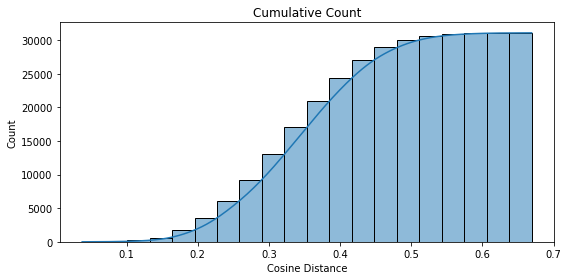

In [83]:
plt.figure(figsize=(8,4), tight_layout=True)
ax = sns.histplot(cos_dis, cumulative=True, bins=20, kde=True)
ax.set(title="Cumulative Count", xlabel="Cosine Distance", ylabel="Count")
plt.show()